In [86]:
#imports here 
import pandas as pd
import numpy as np
import os
import cv2
import pydicom
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import glob
from tqdm import tqdm
import math

In [87]:
#EDA on 1st dataset(worldwidecovid)
path_data_1_combined = "/kaggle/input/world-wide-covid-dataset/PROSTATE_MRI"
#read metadata sheet
df = pd.read_csv(os.path.join(path_data_1_combined,'metadata.csv'))

In [88]:
print(df.head())
#this tells us that multiple mri scans have been taken for each patient

                                          Series UID    Collection  \
0  1.3.6.1.4.1.14519.5.2.1.9823.1001.165695987073...  PROSTATE-MRI   
1  1.3.6.1.4.1.14519.5.2.1.9823.1001.124620957890...  PROSTATE-MRI   
2  1.3.6.1.4.1.14519.5.2.1.9823.1001.124348664925...  PROSTATE-MRI   
3  1.3.6.1.4.1.14519.5.2.1.9823.1001.249502735639...  PROSTATE-MRI   
4  1.3.6.1.4.1.14519.5.2.1.9823.1001.337753368395...  PROSTATE-MRI   

   3rd Party Analysis                           Data Description URI  \
0                 NaN  https://doi.org/10.7937/K9/TCIA.2016.6046GUDv   
1                 NaN  https://doi.org/10.7937/K9/TCIA.2016.6046GUDv   
2                 NaN  https://doi.org/10.7937/K9/TCIA.2016.6046GUDv   
3                 NaN  https://doi.org/10.7937/K9/TCIA.2016.6046GUDv   
4                 NaN  https://doi.org/10.7937/K9/TCIA.2016.6046GUDv   

             Subject ID                                          Study UID  \
0  MIP-PROSTATE-01-0001  1.3.6.1.4.1.14519.5.2.1.9823.1001.120983205

In [89]:
print(df)

                                            Series UID    Collection  \
0    1.3.6.1.4.1.14519.5.2.1.9823.1001.165695987073...  PROSTATE-MRI   
1    1.3.6.1.4.1.14519.5.2.1.9823.1001.124620957890...  PROSTATE-MRI   
2    1.3.6.1.4.1.14519.5.2.1.9823.1001.124348664925...  PROSTATE-MRI   
3    1.3.6.1.4.1.14519.5.2.1.9823.1001.249502735639...  PROSTATE-MRI   
4    1.3.6.1.4.1.14519.5.2.1.9823.1001.337753368395...  PROSTATE-MRI   
..                                                 ...           ...   
177  1.3.6.1.4.1.14519.5.2.1.9823.1001.533477093780...  PROSTATE-MRI   
178  1.3.6.1.4.1.14519.5.2.1.9823.1001.265206328399...  PROSTATE-MRI   
179  1.3.6.1.4.1.14519.5.2.1.9823.1001.289941266194...  PROSTATE-MRI   
180  1.3.6.1.4.1.14519.5.2.1.9823.1001.263616732878...  PROSTATE-MRI   
181  1.3.6.1.4.1.14519.5.2.1.9823.1001.255470204300...  PROSTATE-MRI   

     3rd Party Analysis                           Data Description URI  \
0                   NaN  https://doi.org/10.7937/K9/TCIA.2016

In [90]:
#average number of scans per patient 
#for that pick the number of columns 
#this sheet can be used for us to iterate the files as necessary
#SubjectID identifies the patient
print("Number of Rows:",len(df["Number of Images"]))
#indicate the number of unique patients

Number of Rows: 182


In [91]:
total = 0
for rowdata in df['Number of Images']:
    total+=rowdata
print("The Average number of MRI scans each patient underwent are:",total/182)

The Average number of MRI scans each patient underwent are: 121.07692307692308


In [92]:
#methodologies used and ranking
methods_unique = set()
for method in df['Series Description']:
    methods_unique.add(method)

In [93]:
print("Protocols used:",methods_unique)

Protocols used: {'DCE Pre 4xSOVS P5S1', 'DCE 262 pre', 'DCE Pre 4xSOVS P4S2', 'dSShDWI SENSE', 'SShDWI FAST', 'T2 TSE ax hi', 'DCE 5.6s 4xSOVS P4S2', 'T2 TSE sag', 'DCE 5.6s 4xSOVS P5S1', 'T1 FA2 4xSOVS P5S1 inphase', 'DCE Pre 4xSOVS P5S2', 'T2 TSE cor', 'DCE 262 3.1'}


In [94]:
print("Number of unique protocols used:",len(methods_unique))

Number of unique protocols used: 13


In [95]:
#find out the most used technique for mri
max_count = 0
count = 0
method_max = ''
for ele in methods_unique:
    for method in df['Series Description']:
        if(ele == method):
            count+=1
    if count>=max_count:
        max_count = count
        count = 0
        method_max = ele
        print(method_max)
        print(max_count)
print("The most used method is:",method_max)

DCE Pre 4xSOVS P5S1
14
dSShDWI SENSE
32
T2 TSE ax hi
52
DCE Pre 4xSOVS P5S2
53
The most used method is: DCE Pre 4xSOVS P5S2


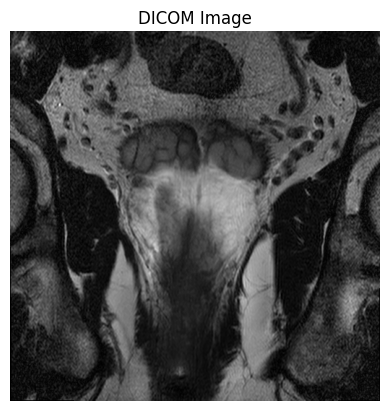

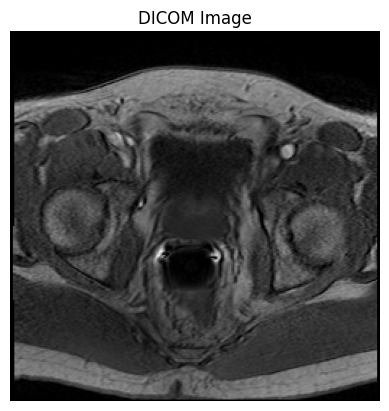

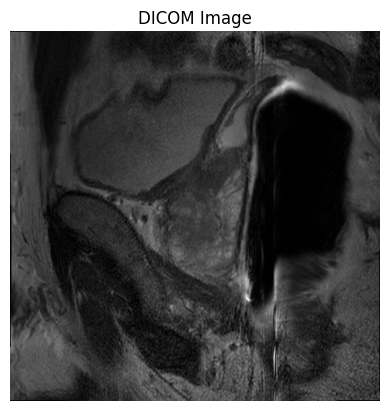

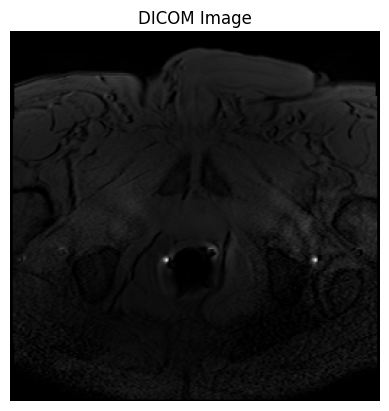

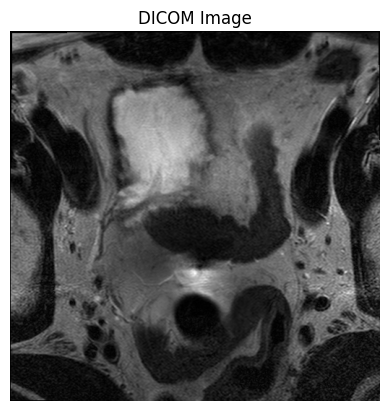

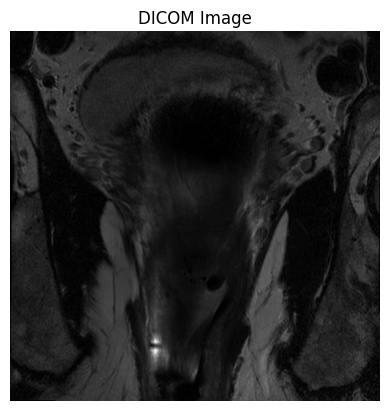

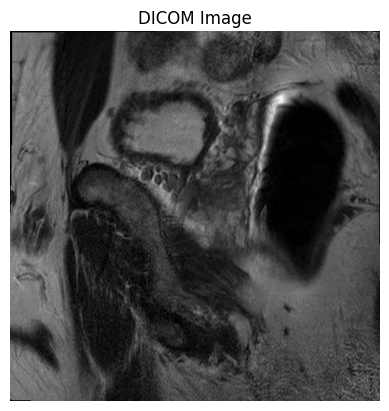

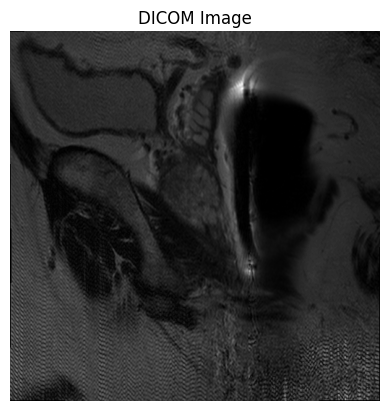

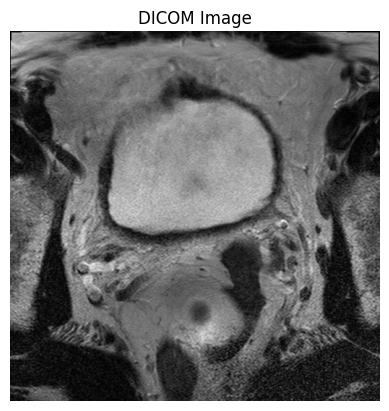

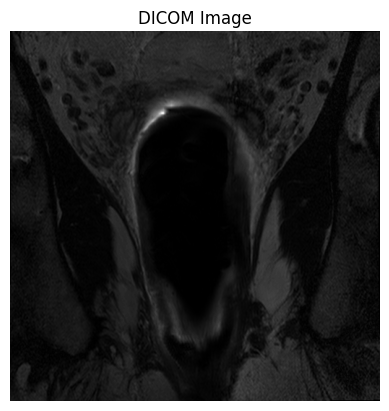

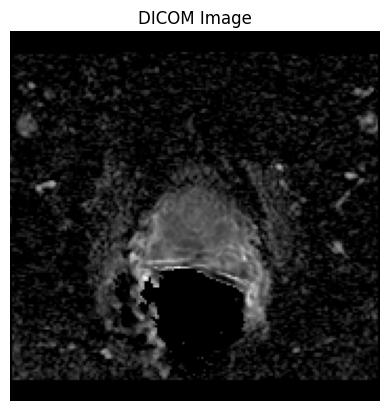

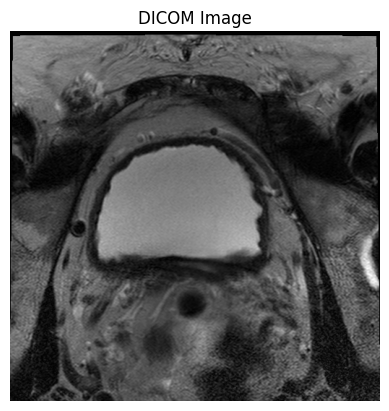

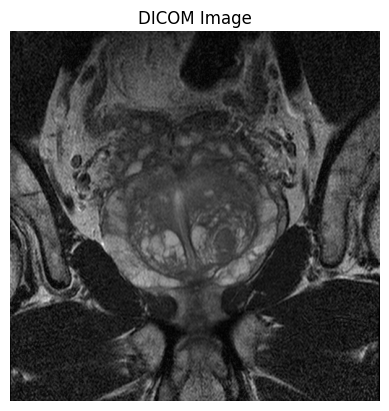

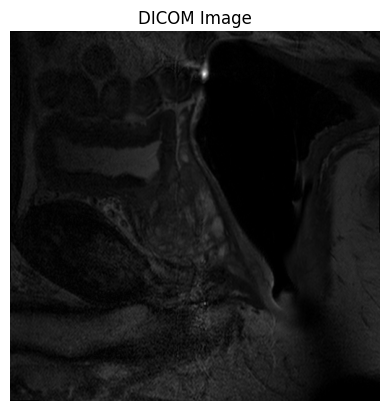

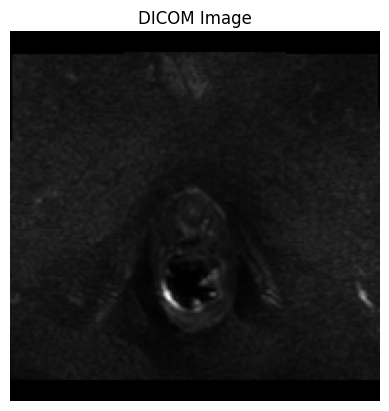

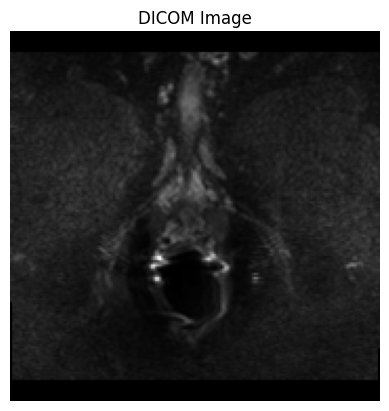

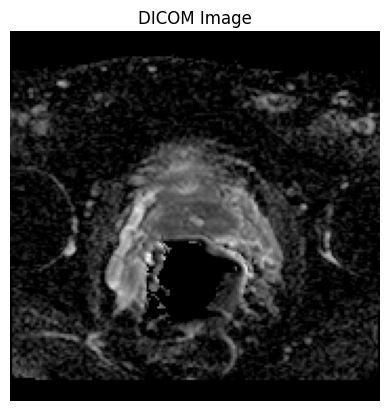

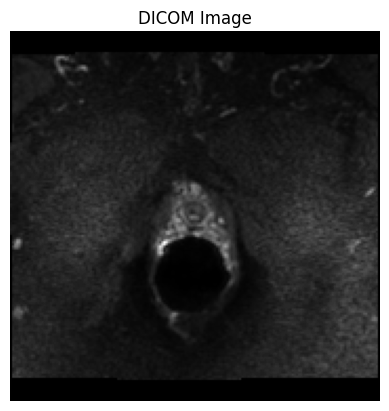

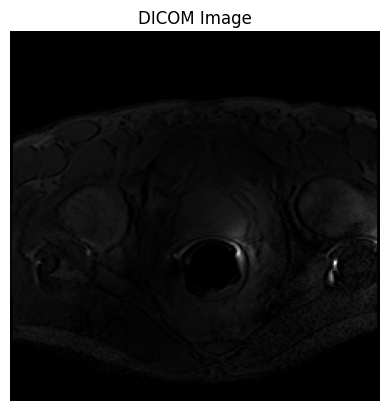

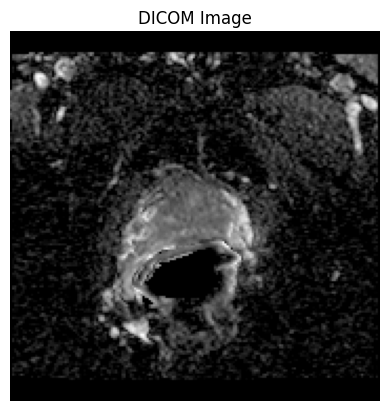

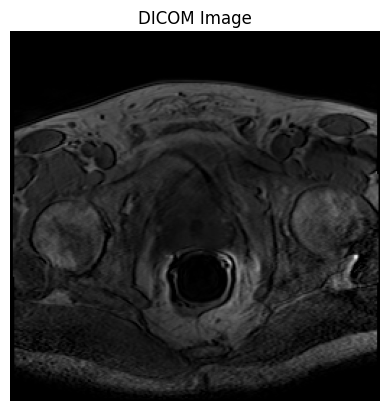

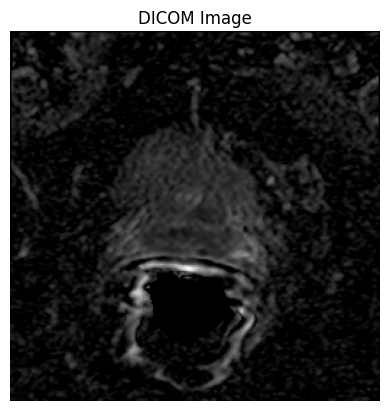

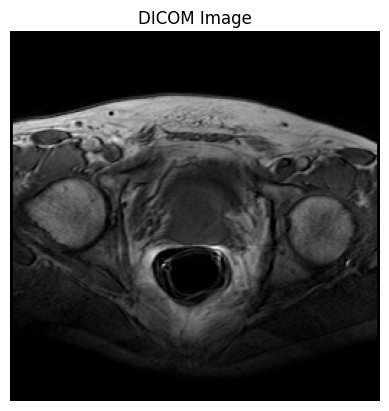

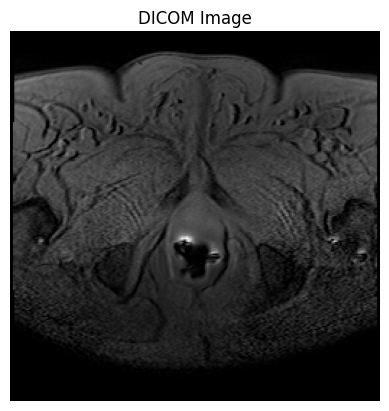

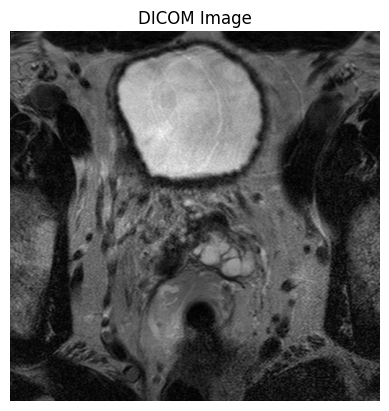

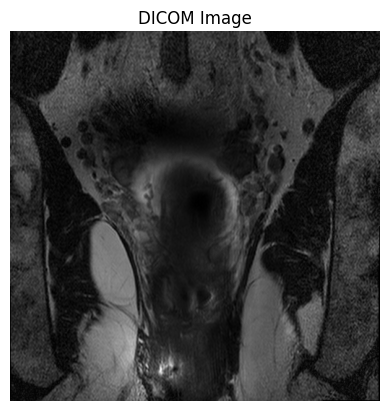

In [96]:
# Path to the combined directory containing DICOM files
combined_path = os.path.join(path_data_1_combined, "PROSTATE-MRI")

# Iterate over each directory in the combined path
for direct in os.listdir(combined_path):
    image_path = os.path.join(combined_path, direct)
    
    # Only process directories (you might want to add additional checks here)
    if os.path.isdir(image_path) and direct != 'LICENSE':
        counter = 0
        # Use os.walk to iterate through the files in the directory
        for dirpath, dirnames, filenames in os.walk(image_path):
            # Only read one DICOM file
            for filename in filenames:
                # Construct the full path to the DICOM file
                file_path = os.path.join(dirpath, filename)
                
                # Check if the file is a DICOM file
                if filename.lower().endswith('.dcm') and counter < 1:
                    ds = pydicom.dcmread(file_path)
                    # Access pixel data
                    if 'PixelData' in ds:
                        pixel_array = ds.pixel_array

                        # Display the image
                        plt.imshow(pixel_array, cmap='gray')  # Use 'gray' colormap for grayscale images
                        plt.title('DICOM Image')
                        plt.axis('off')  # Hide axes
                        plt.show()
                        counter += 1
                    else:
                        print("No pixel data found in this DICOM file.")


In [97]:
#eda on prostatemriusbiopsy
path_to_2_combined = "/kaggle/input/prostate-mri-us-biopsy"
df2 = pd.read_csv(os.path.join(path_to_2_combined , 'metadata.csv'))

In [98]:
print(df2.head())

                                          Series UID              Collection  \
0  1.3.6.1.4.1.14519.5.2.1.1403678967890026014493...  Prostate-MRI-US-Biopsy   
1  1.3.6.1.4.1.14519.5.2.1.2667179699843439819630...  Prostate-MRI-US-Biopsy   
2  1.3.6.1.4.1.14519.5.2.1.1202285930413120999892...  Prostate-MRI-US-Biopsy   
3  1.3.6.1.4.1.14519.5.2.1.1867491288236660505887...  Prostate-MRI-US-Biopsy   
4  1.3.6.1.4.1.14519.5.2.1.2007760325377179554571...  Prostate-MRI-US-Biopsy   

   3rd Party Analysis                        Data Description URI  \
0                 NaN  https://doi.org/10.7937/TCIA.2020.A61IOC1A   
1                 NaN  https://doi.org/10.7937/TCIA.2020.A61IOC1A   
2                 NaN  https://doi.org/10.7937/TCIA.2020.A61IOC1A   
3                 NaN  https://doi.org/10.7937/TCIA.2020.A61IOC1A   
4                 NaN  https://doi.org/10.7937/TCIA.2020.A61IOC1A   

                    Subject ID  \
0  Prostate-MRI-US-Biopsy-0001   
1  Prostate-MRI-US-Biopsy-0001   
2 

In [99]:
excel_for_dataset = '/kaggle/input/prostate-mri-us-biopsy/TCIA Biopsy Data_2020-07-14.xlsx'
df3 = pd.read_excel(excel_for_dataset)

In [100]:
print(df3.head())

   PSA (ng/mL)  Primary Gleason  Secondary Gleason  Cancer Length (mm)  \
0         10.9              NaN                NaN                 NaN   
1         10.9              3.0                4.0                 4.0   
2         10.9              3.0                3.0                 2.0   
3         10.9              NaN                NaN                 NaN   
4         10.9              NaN                NaN                 NaN   

   % Cancer in Core  Core Fragment #1 Tissue Length (mm)  \
0               NaN                                 10.0   
1              50.0                                 14.0   
2              10.0                                 10.0   
3               NaN                                 12.0   
4               NaN                                 14.0   

   Core Fragment #2 Tissue Length (mm)  Core Fragment #3 Tissue Length (mm)  \
0                                  3.0                                  NaN   
1                                  N

In [101]:
print(df3.columns)

Index(['PSA (ng/mL)', 'Primary Gleason', 'Secondary Gleason',
       'Cancer Length (mm)', '% Cancer in Core',
       'Core Fragment #1 Tissue Length (mm)',
       'Core Fragment #2 Tissue Length (mm)',
       'Core Fragment #3 Tissue Length (mm)', 'Bx Tip X (MRI Coord)',
       'Bx Tip Y (MRI Coord)', 'Bx Tip Z (MRI Coord)', 'Bx Base X (MRI Coord)',
       'Bx Base Y (MRI Coord)', 'Bx Base Z (MRI Coord)', 'Bx Tip X (US Coord)',
       'Bx Tip Y (US Coord)', 'Bx Tip Z (US Coord)', 'Bx Base X (US Coord)',
       'Bx Base Y (US Coord)', 'Bx Base Z (US Coord)', 'Prostate Volume (CC)',
       'Core Label', 'Series Instance UID (US)', 'Series Instance UID (MRI)',
       'Patient Number'],
      dtype='object')


In [102]:
excel_dataset_2 = "/kaggle/input/prostate-mri-us-biopsy/Target Data_2019-12-05.xlsx"
df4 = pd.read_excel(excel_dataset_2)

In [103]:
print(df4.head())

   UCLA Score (Similar to PIRADS v2)  ROI Volume (cc)  Target No.  \
0                                  3         0.834323           1   
1                                  3         0.834323           1   
2                                  1         0.364729           1   
3                                  3         0.364729           1   
4                                  3         0.884436           1   

                                seriesInstanceUID_US  \
0  1.3.6.1.4.1.14519.5.2.1.1403678967890026014493...   
1  1.3.6.1.4.1.14519.5.2.1.1202285930413120999892...   
2  1.3.6.1.4.1.14519.5.2.1.9782151183163602689533...   
3  1.3.6.1.4.1.14519.5.2.1.2007760325377179554571...   
4  1.3.6.1.4.1.14519.5.2.1.9358385420720256123337...   

                                seriesInstanceUID_MR  \
0  1.3.6.1.4.1.14519.5.2.1.2667179699843439819630...   
1  1.3.6.1.4.1.14519.5.2.1.2667179699843439819630...   
2  1.3.6.1.4.1.14519.5.2.1.1867491288236660505887...   
3  1.3.6.1.4.1.14519.5.2

In [104]:
print("Number of Rows:",len(df2["Number of Images"]))

Number of Rows: 2779


In [105]:
total = 0
for rowdata in df2['Number of Images']:
    total+=rowdata
print("The Average number of MRI scans each patient underwent are:",total/2779)

The Average number of MRI scans each patient underwent are: 21.99316300827636


In [106]:
#methodologies used and ranking
methods_unique2 = set()
for method in df2['Series Description']:
    methods_unique2.add(method)

In [107]:
print("Protocols used:",methods_unique2)

Protocols used: {'AX T2', 't2tsetra obl 3mm', 't2spcrstaxialProstate', 't2spcrstaxialp2', 'AX OBL T2 BLADE SMFOV', 't2spcrstax oblp2', 'T2 Ax SPACE Prostate PlaneTop of Bladder-Thru Prostate', 'AX T2 FSE', 'AX T2 PROPELLER', 'AX T2 FSE 3mm', 'T2 AX', 'Ax T2 HR  FRFSE', 't2spcrstaxp2', 't2spcrstaxialProstate rpt', 't2spcrstaxial oblProstate rpt', 'T2WTSE AX HI', 'Ax T2', 't2spcrstaxial Prostate', 'AXT2', 'AX T2 TSE', 'T2 SPACE 3D AXIAL', 'SCAx T2 FSE', 'Ax Cube T2-100ETL2Rx', 't2tsetraprostate', 't2spcrstaxial oblp2', 't2tsetra320p2', 't2spctrap2rstaxialProstate', 'AX T2tseSMFOV', 'Axial T2', nan, 'AX FSE T2 SMALL', 'T2 AX TSE SMALL FOV', 'reprat t2spcrstaxial oblProstate', 't2tsetra', 'AX T2 SM FOV', 'T2 Ax', 't2spcrstaxial oblProstate', 't2spctrap2rstaxial oblProstate', 'AX T2 NO ANGLE', 't2tsecor', 'AX OB T2WTSE', 'Ax T2 FRFSE PROP', 't2spcrstaxial oblRPT', 'Ax T2 PROPELLER'}


In [108]:
print("Number of unique protocols used:",len(methods_unique2))

Number of unique protocols used: 44


In [109]:
#find out the most used technique for mri
max_count = 0
count = 0
method_max = ''
for ele in methods_unique2:
    for method in df2['Series Description']:
        if(ele == method):
            count+=1
    if count>=max_count:
        max_count = count
        count = 0
        method_max = ele
        print(method_max)
        print(max_count)
print("The most used method is:",method_max)

AX T2
8
t2spcrstaxialProstate
68
t2spcrstaxial oblp2
68
t2spcrstaxial oblProstate
858
The most used method is: t2spcrstaxial oblProstate


In [110]:
counter_overlays = 0
for folder in os.listdir(path_3d_overlays):
    path_int = os.path.join(path_3d_overlays, folder)
    
    # Iterate over files in the 'Data' folder
    for file in os.listdir(os.path.join(path_int, 'Data')):
        if file.endswith(".fcsv"):
            counter_overlays+=1
print("the total overlays are:",counter_overlays)

the total overlays are: 43193


In [111]:
path_to_stl = "/kaggle/input/prostate-mri-us-biopsy/STLs/STLs/"
counter_stl = 0

for stlfile in os.listdir(path_to_stl):
    counter_stl+=1
print("The Number of stl ultrasound files are:",counter_stl)

The Number of stl ultrasound files are: 5717


Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0666/10-28-2006-NA-3D Rendering-30633/96.000000-NA-55449/1-1.dcm


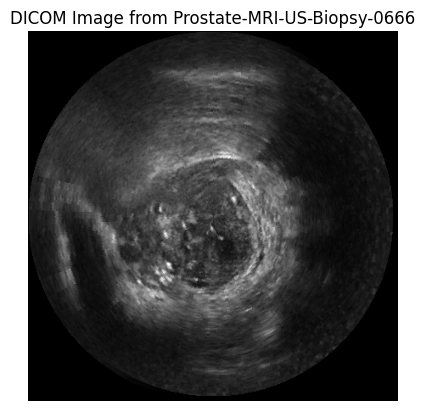

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0666/08-21-2006-NA-MRI PROSTATE W ENDORECTAL COIL-20604/10.000000-t2spcrstaxial oblProstate-72151/1-26.dcm


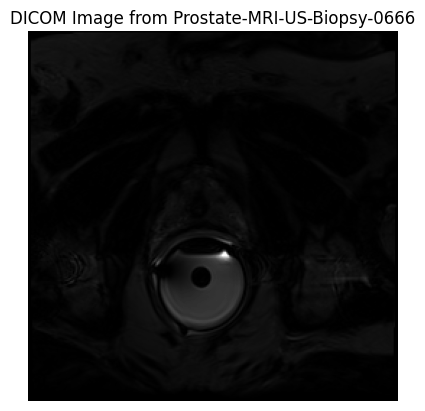

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0581/11-14-2005-NA-MRI PROSTATE W WO CONTRAST-12625/7.000000-t2spcrstaxial oblProstate-82455/1-26.dcm


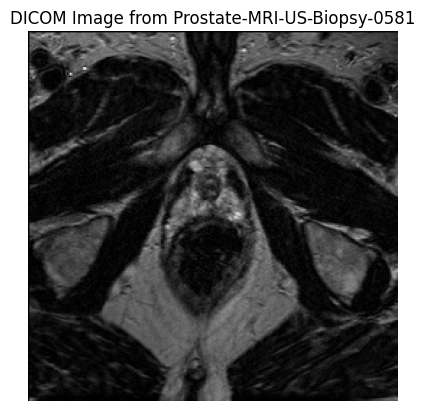

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0581/02-20-2006-NA-3D Rendering-08958/2.000000-NA-35188/1-1.dcm


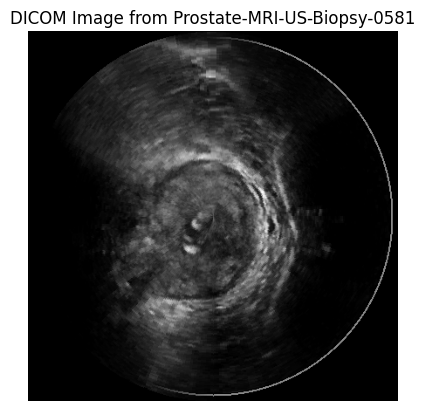

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0625/12-11-2005-NA-MRI PROSTATE W WO CONTRAST-38442/5.000000-t2spcrstaxial oblProstate-25421/1-26.dcm


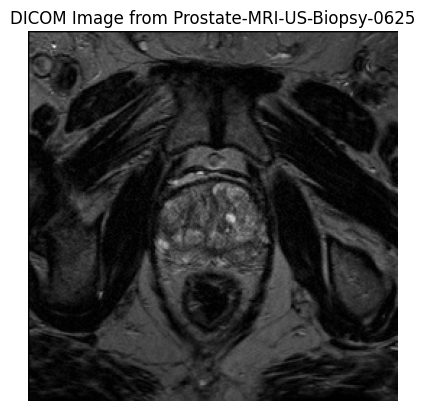

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0625/02-26-2006-NA-3D Rendering-44640/73.000000-NA-18237/1-1.dcm


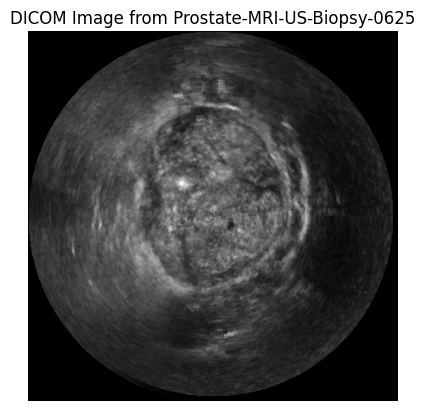

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0406/05-03-2009-NA-MRI PROSTATE W WO CONTRAST-76439/13.000000-t2spcrstaxial oblProstate-40290/1-26.dcm


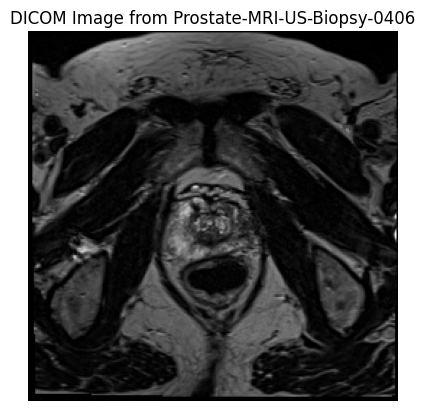

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0406/05-09-2009-NA-NA-35978/377.000000-NA-96241/1-1.dcm


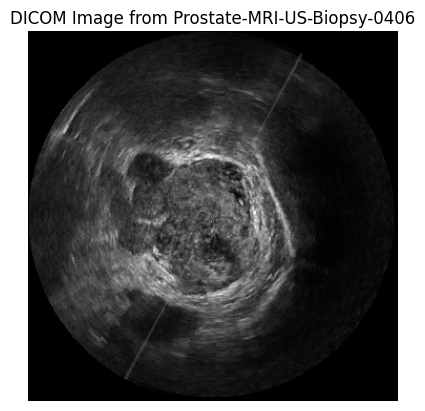

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0644/03-04-2006-NA-3D Rendering-35069/76.000000-NA-02249/1-1.dcm


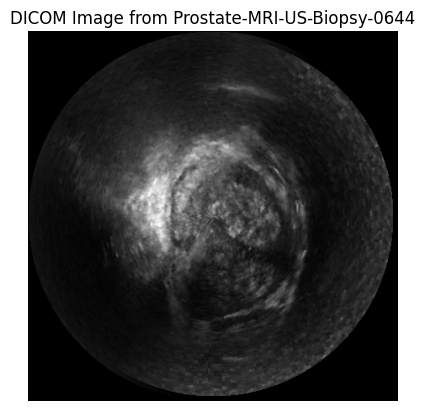

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0495/01-09-2010-NA-3D Rendering-35643/99.000000-NA-05432/1-1.dcm


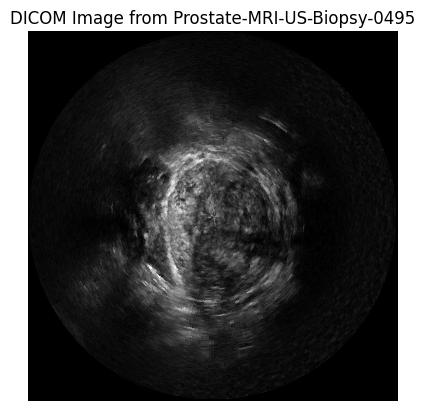

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0495/01-07-2010-NA-MRI PROSTATE W WO CONTRAST-96894/13001.000000-t2spcrstaxial oblProstate-19466/1-26.dcm


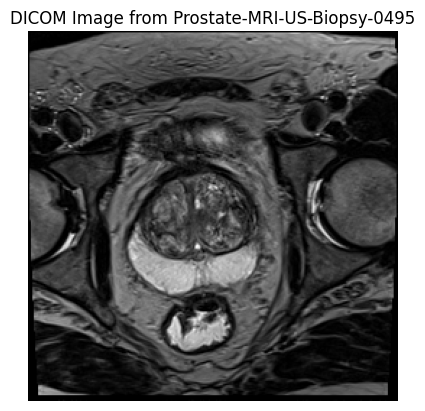

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-1072/03-15-2010-NA-MR PELVIS OUTSIDE IMAGING-89950/6.000000-AX OBL T2 BLADE SMFOV-55121/1-26.dcm


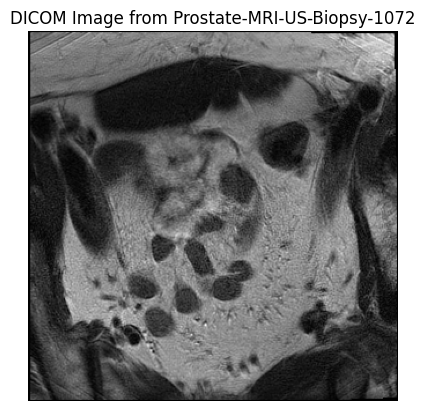

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-1072/05-07-2010-NA-NA-14427/53.000000-NA-59118/1-1.dcm


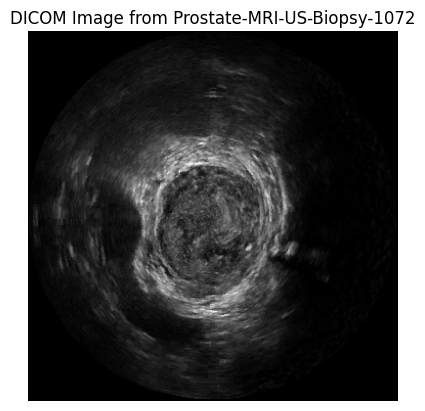

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0650/02-19-2006-NA-3D Rendering-97076/4.000000-NA-01021/1-1.dcm


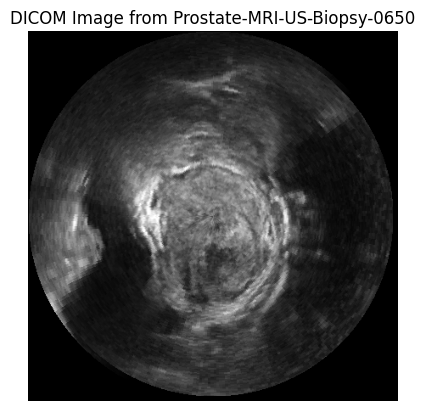

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0650/02-17-2006-NA-MRI PROSTATE W WO CONTRAST-91235/2.000000-t2spcrstaxialp2-33355/1-26.dcm


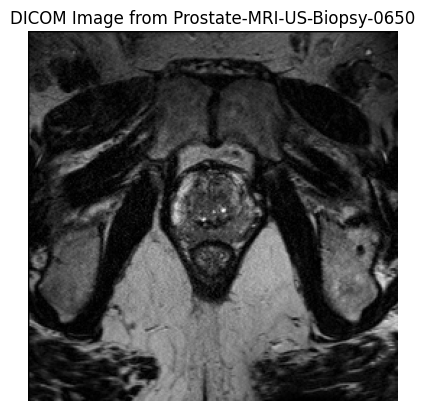

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0313/11-13-2009-NA-3D Rendering-47425/36.000000-NA-06941/1-1.dcm


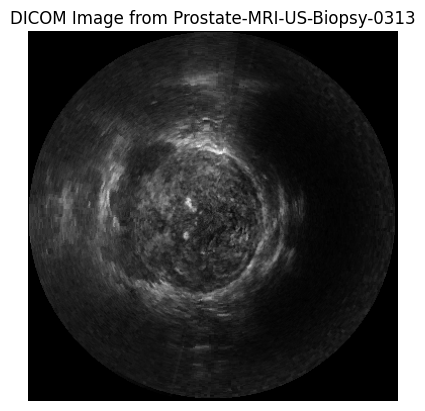

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0107/03-12-2006-NA-3D Rendering-37591/78.000000-NA-31670/1-1.dcm


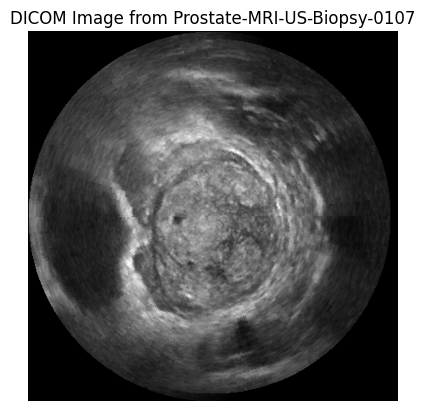

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0497/05-23-2008-NA-3D Rendering-70196/256.000000-NA-16940/1-1.dcm


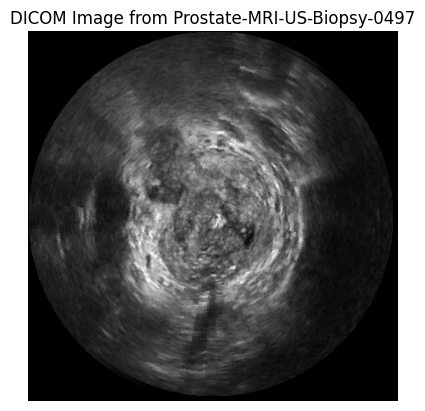

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0497/05-18-2009-NA-3D Rendering-10434/152.000000-NA-29515/1-1.dcm


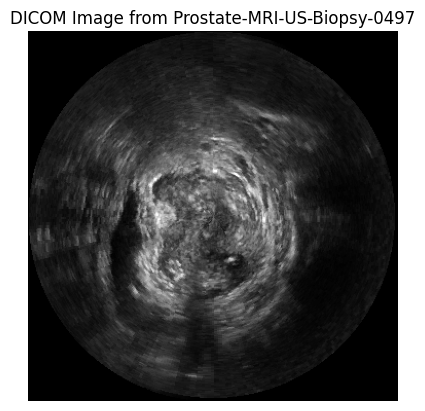

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0467/06-06-2008-NA-3D Rendering-86772/225.000000-NA-45851/1-1.dcm


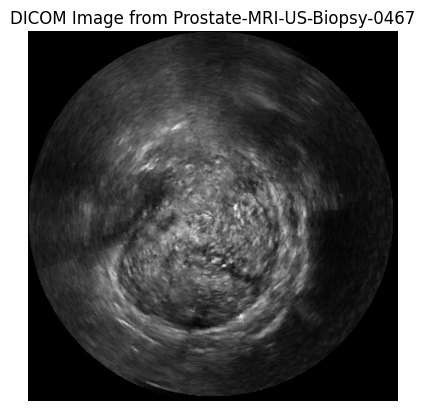

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0467/05-14-2008-NA-MRI PROSTATE W WO CONTRAST-68503/9.000000-t2spcrstaxial oblProstate-78083/1-26.dcm


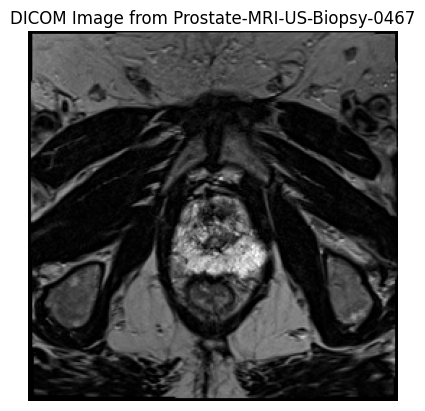

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0188/02-16-2010-NA-MRI PROSTATE W WO CONTRAST-80612/8.000000-t2spcrstaxial oblProstate-58161/1-26.dcm


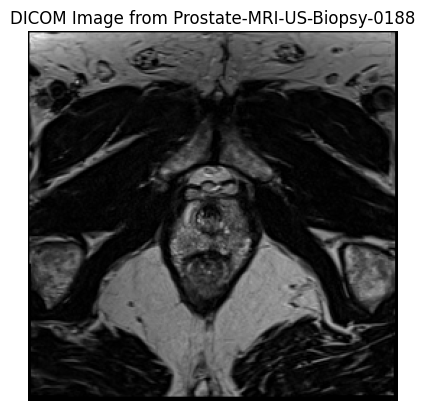

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0188/02-27-2010-NA-3D Rendering-93127/195.000000-NA-88971/1-1.dcm


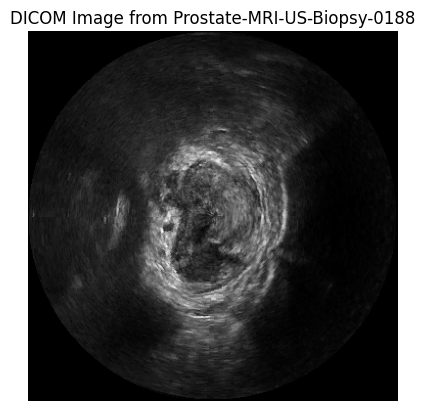

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0858/08-09-2008-NA-3D Rendering-09179/3.000000-NA-45519/1-1.dcm


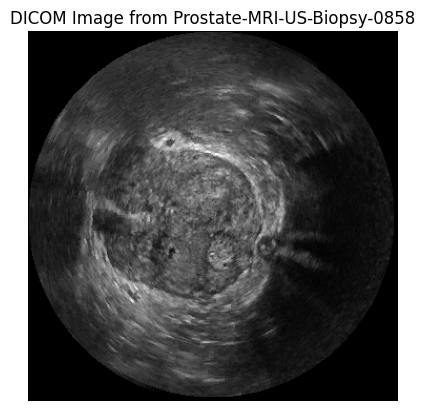

Reading DICOM file: /kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0858/07-26-2009-NA-3D Rendering-61772/107.000000-NA-64364/1-1.dcm


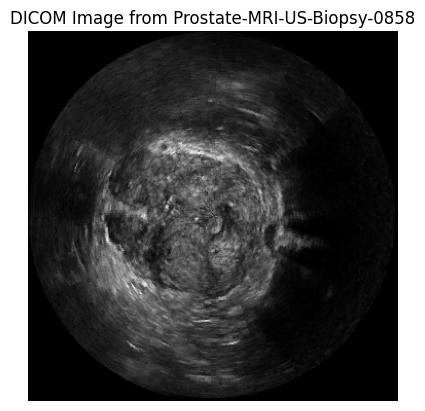

In [112]:
# Path to the MRI biopsy directory
path_to_mri_biopsy = '/kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy/'
limit = 25
counter_limit = 0

# Iterate through each directory in the main directory
for directory in os.listdir(path_to_mri_biopsy):
    directory_path = os.path.join(path_to_mri_biopsy, directory)
    
    # Check if it's a directory
    if os.path.isdir(directory_path) and counter_limit < limit:
        # Use os.walk to traverse subdirectories
        for dirpath, dirnames, filenames in os.walk(directory_path):
            # Find the first DICOM file
            for filename in filenames:
                # Construct the full path to the DICOM file
                if filename.lower().endswith('.dcm'):  # Check for DICOM files
                    file_path = os.path.join(dirpath, filename)
                    print(f"Reading DICOM file: {file_path}")
                    
                    ds = pydicom.dcmread(file_path)
                    
                    # Access pixel data
                    if 'PixelData' in ds:
                        pixel_array = ds.pixel_array

                        # Check the shape of the pixel array
                        if pixel_array.ndim == 3:
                            # If it's 3D, display the middle slice
                            mid_slice = pixel_array[pixel_array.shape[0] // 2, :, :]
                            plt.imshow(mid_slice, cmap='gray')
                        elif pixel_array.ndim == 2:
                            # If it's 2D, display it directly
                            plt.imshow(pixel_array, cmap='gray')
                        else:
                            print("Unexpected number of dimensions in pixel data.")
                            
                        plt.title(f'DICOM Image from {directory}')
                        plt.axis('off')  # Hide axes
                        plt.show()
                        
                        counter_limit += 1  # Increment the counter
                        break  # Break after showing the first DICOM image for this directory

                if counter_limit >= limit:  # Check if limit is reached
                    break  # Exit the loop if limit is reached

    if counter_limit >= limit:  # Check if limit is reached
        break  # Exit the outer loop if limit is reached

In [113]:
# Merge DataFrames on different column names
combined_df = pd.merge(
    df3, df4,
    left_on=['Patient Number', 'Series Instance UID (US)', 'Series Instance UID (MRI)'],
    right_on=['Patient ID', 'seriesInstanceUID_US', 'seriesInstanceUID_MR'],
    how='inner'
)

# Drop unnecessary columns after merging
combined_df.drop(['Patient Number', 'Patient ID', 
                  'Series Instance UID (US)', 'seriesInstanceUID_US', 
                  'Series Instance UID (MRI)', 'seriesInstanceUID_MR'], 
                 axis=1, inplace=True, errors='ignore')

# Print the combined DataFrame
print(combined_df)


       PSA (ng/mL)  Primary Gleason  Secondary Gleason  Cancer Length (mm)  \
0             10.9              NaN                NaN                 NaN   
1             10.9              3.0                4.0                 4.0   
2             10.9              3.0                3.0                 2.0   
3             10.9              NaN                NaN                 NaN   
4             10.9              NaN                NaN                 NaN   
...            ...              ...                ...                 ...   
23492          7.1              3.0                4.0                 7.0   
23493          7.1              NaN                NaN                 NaN   
23494          7.1              NaN                NaN                 NaN   
23495          7.1              NaN                NaN                 NaN   
23496          7.1              NaN                NaN                 NaN   

       % Cancer in Core  Core Fragment #1 Tissue Length (mm)  \

In [114]:
print(combined_df.columns)

Index(['PSA (ng/mL)', 'Primary Gleason', 'Secondary Gleason',
       'Cancer Length (mm)', '% Cancer in Core',
       'Core Fragment #1 Tissue Length (mm)',
       'Core Fragment #2 Tissue Length (mm)',
       'Core Fragment #3 Tissue Length (mm)', 'Bx Tip X (MRI Coord)',
       'Bx Tip Y (MRI Coord)', 'Bx Tip Z (MRI Coord)', 'Bx Base X (MRI Coord)',
       'Bx Base Y (MRI Coord)', 'Bx Base Z (MRI Coord)', 'Bx Tip X (US Coord)',
       'Bx Tip Y (US Coord)', 'Bx Tip Z (US Coord)', 'Bx Base X (US Coord)',
       'Bx Base Y (US Coord)', 'Bx Base Z (US Coord)', 'Prostate Volume (CC)',
       'Core Label', 'UCLA Score (Similar to PIRADS v2)', 'ROI Volume (cc)',
       'Target No.'],
      dtype='object')


In [115]:
print(combined_df.head())

   PSA (ng/mL)  Primary Gleason  Secondary Gleason  Cancer Length (mm)  \
0         10.9              NaN                NaN                 NaN   
1         10.9              3.0                4.0                 4.0   
2         10.9              3.0                3.0                 2.0   
3         10.9              NaN                NaN                 NaN   
4         10.9              NaN                NaN                 NaN   

   % Cancer in Core  Core Fragment #1 Tissue Length (mm)  \
0               NaN                                 10.0   
1              50.0                                 14.0   
2              10.0                                 10.0   
3               NaN                                 12.0   
4               NaN                                 14.0   

   Core Fragment #2 Tissue Length (mm)  Core Fragment #3 Tissue Length (mm)  \
0                                  3.0                                  NaN   
1                                  N

In [116]:
print(df3.shape)

(24783, 25)


In [117]:
print(df4.shape)

(1621, 6)


In [118]:
print(combined_df.columns.tolist())

['PSA (ng/mL)', 'Primary Gleason', 'Secondary Gleason', 'Cancer Length (mm)', '% Cancer in Core', 'Core Fragment #1 Tissue Length (mm)', 'Core Fragment #2 Tissue Length (mm)', 'Core Fragment #3 Tissue Length (mm)', 'Bx Tip X (MRI Coord)', 'Bx Tip Y (MRI Coord)', 'Bx Tip Z (MRI Coord)', 'Bx Base X (MRI Coord)', 'Bx Base Y (MRI Coord)', 'Bx Base Z (MRI Coord)', 'Bx Tip X (US Coord)', 'Bx Tip Y (US Coord)', 'Bx Tip Z (US Coord)', 'Bx Base X (US Coord)', 'Bx Base Y (US Coord)', 'Bx Base Z (US Coord)', 'Prostate Volume (CC)', 'Core Label', 'UCLA Score (Similar to PIRADS v2)', 'ROI Volume (cc)', 'Target No.']


In [119]:
combined_df.columns = combined_df.columns.str.strip()

In [120]:
print(combined_df.columns.tolist())

['PSA (ng/mL)', 'Primary Gleason', 'Secondary Gleason', 'Cancer Length (mm)', '% Cancer in Core', 'Core Fragment #1 Tissue Length (mm)', 'Core Fragment #2 Tissue Length (mm)', 'Core Fragment #3 Tissue Length (mm)', 'Bx Tip X (MRI Coord)', 'Bx Tip Y (MRI Coord)', 'Bx Tip Z (MRI Coord)', 'Bx Base X (MRI Coord)', 'Bx Base Y (MRI Coord)', 'Bx Base Z (MRI Coord)', 'Bx Tip X (US Coord)', 'Bx Tip Y (US Coord)', 'Bx Tip Z (US Coord)', 'Bx Base X (US Coord)', 'Bx Base Y (US Coord)', 'Bx Base Z (US Coord)', 'Prostate Volume (CC)', 'Core Label', 'UCLA Score (Similar to PIRADS v2)', 'ROI Volume (cc)', 'Target No.']


In [121]:
#label encode the columns that are categorical 
encoder = LabelEncoder()

combined_df['Core Label Encoded'] = encoder.fit_transform(combined_df['Core Label'])

combined_df.drop('Core Label', axis=1, inplace=True)

print(combined_df)

       PSA (ng/mL)  Primary Gleason  Secondary Gleason  Cancer Length (mm)  \
0             10.9              NaN                NaN                 NaN   
1             10.9              3.0                4.0                 4.0   
2             10.9              3.0                3.0                 2.0   
3             10.9              NaN                NaN                 NaN   
4             10.9              NaN                NaN                 NaN   
...            ...              ...                ...                 ...   
23492          7.1              3.0                4.0                 7.0   
23493          7.1              NaN                NaN                 NaN   
23494          7.1              NaN                NaN                 NaN   
23495          7.1              NaN                NaN                 NaN   
23496          7.1              NaN                NaN                 NaN   

       % Cancer in Core  Core Fragment #1 Tissue Length (mm)  \

In [122]:
columns_to_fill = ['Secondary Gleason','Cancer Length (mm)','% Cancer in Core', 'Core Fragment #1 Tissue Length (mm)', 'Core Fragment #2 Tissue Length (mm)' , 'Core Fragment #3 Tissue Length (mm)']

for column in columns_to_fill:
    combined_df[column] = combined_df[column].fillna(0)

In [123]:
combined_df.head()

PSA (ng/mL)  Primary Gleason  Secondary Gleason  Cancer Length (mm)  \
0         10.9              NaN                0.0                 0.0   
1         10.9              3.0                4.0                 4.0   
2         10.9              3.0                3.0                 2.0   
3         10.9              NaN                0.0                 0.0   
4         10.9              NaN                0.0                 0.0   

   % Cancer in Core  Core Fragment #1 Tissue Length (mm)  \
0               0.0                                 10.0   
1              50.0                                 14.0   
2              10.0                                 10.0   
3               0.0                                 12.0   
4               0.0                                 14.0   

   Core Fragment #2 Tissue Length (mm)  Core Fragment #3 Tissue Length (mm)  \
0                                  3.0                                  0.0   
1                                  0.0                                  0.0   
2                                  2.0                                  1.0   
3                                  4.0                                  0.0   
4                                  0.0                                  0.0   

   Bx Tip X (MRI Coord)  Bx Tip Y (MRI Coord)  ...  Bx Tip Y (US Coord)  \
0                -8.915                34.791  ...               12.970   
1                -5.644                23.161  ...                6.628   
2                -9.642                22.070  ...               10.436   
3               -11.095                30.429  ...               -0.950   
4               -18.001                25.705  ...                8.100   

   Bx Tip Z (US Coord)  Bx Base X (US Coord)  Bx Base Y (US Coord)  \
0                9.888                14.970                30.545   
1                1.831                19.342                23.864   
2               -5.368                16.782                27.651   
3               17.006                10.307                15.876   
4               -2.421                11.157                26.813   

   Bx Base Z (US Coord)  Prostate Volume (CC)  \
0                 8.399              49.14195   
1                 2.066              49.14195   
2                -2.674              49.14195   
3                15.351              49.14195   
4                -1.681              49.14195   

   UCLA Score (Similar to PIRADS v2)  ROI Volume (cc)  Target No.  \
0                                  3         0.834323           1   
1                                  3         0.834323           1   
2                                  3         0.834323           1   
3                                  3         0.834323           1   
4                                  3         0.834323           1   

   Core Label Encoded  
0                   4  
1                   5  
2                   3  
3                   2  
4                   6  

[5 rows x 25 columns]

In [124]:
combined_df['Primary Gleason'].fillna(combined_df['Primary Gleason'].mode()[0], inplace=True)

/tmp/ipykernel_30/3130674572.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['Primary Gleason'].fillna(combined_df['Primary Gleason'].mode()[0], inplace=True)


In [125]:
print(combined_df)

       PSA (ng/mL)  Primary Gleason  Secondary Gleason  Cancer Length (mm)  \
0             10.9              3.0                0.0                 0.0   
1             10.9              3.0                4.0                 4.0   
2             10.9              3.0                3.0                 2.0   
3             10.9              3.0                0.0                 0.0   
4             10.9              3.0                0.0                 0.0   
...            ...              ...                ...                 ...   
23492          7.1              3.0                4.0                 7.0   
23493          7.1              3.0                0.0                 0.0   
23494          7.1              3.0                0.0                 0.0   
23495          7.1              3.0                0.0                 0.0   
23496          7.1              3.0                0.0                 0.0   

       % Cancer in Core  Core Fragment #1 Tissue Length (mm)  \

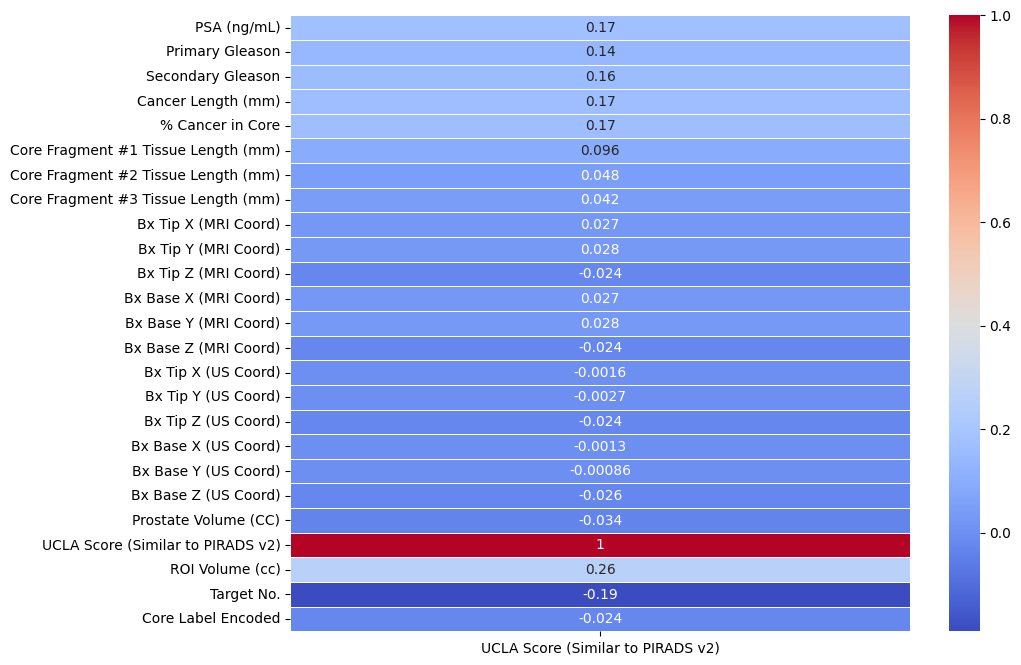

In [126]:
# Calculate the correlation matrix
corr = combined_df.corr()

# Select correlations with UCLA Score
ucla_corr = corr[['UCLA Score (Similar to PIRADS v2)']]

# Create the heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(ucla_corr, annot=True, cmap='coolwarm', linewidths=0.5)

# Save the plot
plt.savefig('ucla_score_corr_map.jpg', dpi=300)  # Save the heatmap as a JPEG file

# Show the plot
plt.show()  # Display the heatmap

In [137]:
#this preprocessing has been taken from the research paper's code itself to convert to jpg files
images_to_use = 25
x_crop = 56
y_crop = 56
folder_path = "/kaggle/input/prostate-mri-us-biopsy/prostate_mri_us_biopsy/Prostate-MRI-US-Biopsy"
output_folder_path = "/kaggle/working"

In [143]:
def process_folder(folder_path):
    
    """
    process_folder processes DCOM images in the folder
    
    :param folder_path: folder to process
    :return: jpg_list,dcm_values
    """ 
    
    jpg_list = []
    dcm_values = []
    
    images_path = os.listdir(folder_path)

    for image in images_path:
        full_path = os.path.join(folder_path, image)
        if image.endswith(".dcm"):
            ds = pydicom.dcmread(full_path)
        
            jpg_image_name = output_folder_path+full_path+".jpg"
            jpg_list.append(jpg_image_name)
                       
            if not os.path.exists(output_folder_path+folder_path):
                os.makedirs(output_folder_path+folder_path)
            
            cv2.imwrite(jpg_image_name, ds.pixel_array)
                               
            patient_name=''
            patient_age=''
            patient_size=''
            patient_weight=''
            patient_eth=''
            patient_occ=''
            patient_smoke=''
            
            try:
                patient_name = ds[0x0010,0x0010].value
            except:
                pass
            
            try:
                patient_age = ds[0x0010,0x1010].value
            except:
                pass
            
            try:
                patient_size = ds[0x0010,0x1020].value
            except:
                pass

            try:
                patient_weight = ds[0x0010,0x1030].value
            except:
                pass
            
            try:
                patient_eth = ds[0x0010,0x2160].value
            except:
                pass            
            
            try:
                patient_occ = ds[0x0010,0x2180].value
            except:
                pass            
            
            try:
                patient_smoke = ds[0x0010,0x21a0].value
            except:
                pass  
            
            dcm_values.append([patient_name,patient_age,patient_size,patient_weight,patient_eth,patient_occ,patient_smoke])
            
    return jpg_list,dcm_values,(output_folder_path+folder_path)

In [139]:
def crop_image(folder_path,x_crop,y_crop):
    
    """
    crop_image crops the image
    
    :param folder_path: folder to process
    :param x_crop: pixel crop x
    :param y_crop: pixel crop y
    """ 
    
    fileList = glob.glob(folder_path + '*jpg*')
    
    # Iterate over images
    for filePath in fileList:
        img = cv2.imread(filePath)
        image_shape_x = img.shape[0]
        image_shape_y = img.shape[1]
                        
        crop_img = img[(0+y_crop):(image_shape_y-y_crop), (0+x_crop):(image_shape_x-x_crop)]
        cv2.imwrite(filePath, crop_img)

In [140]:
def remove_jpg(folder_path):
  
    """
    remove_jpg removes jpg from folder
    
    :param folder_path: folder to process
    """ 
    
    # ==========================================================================================
    # Remove old Final Files
    # ==========================================================================================
    fileList1  = glob.glob(folder_path + '**/*AX_T2*/*jpg*' , recursive=True)
    fileList2 = glob.glob(folder_path + '**/*PROPELLER*/*jpg*' , recursive=True)
    fileList3 = glob.glob(folder_path + '**/*axial*/*jpg*' , recursive=True)
    fileList4 = glob.glob(folder_path + '**/*T2 Ax*/*jpg*' , recursive=True)
    fileList5 = glob.glob(folder_path + '**/*AX T2*/*jpg*' , recursive=True)
    fileList6 = glob.glob(folder_path + '**/*AX */*jpg*' , recursive=True)
    fileList7 = glob.glob(folder_path + '**/*T2 AX*/*jpg*' , recursive=True)
    fileList8 = glob.glob(folder_path + '**/*T2 SPACE*/*jpg*' , recursive=True)
    fileList = fileList1 + fileList2 + fileList3 + fileList4 + fileList5 + fileList6 + fileList7 + fileList8  
        
    # Iterate over the list of filepaths & remove each file.
    for filePath in fileList:    
        try:            
            os.remove(filePath)
        except:
            pass

In [141]:
def make_patient_image(folder_path,images_to_use):
    
    """
    make_patient_image creates images
    
    :param folder_path: folder to process
    :param images_to_use: images to use
    """ 
               
    # ==========================================================================================
    # List all Images
    # ==========================================================================================
    images_path = os.listdir(folder_path)
    image_list = []
        
    for image in images_path:
        full_path = os.path.join(folder_path, image)
        if image.endswith(".jpg"):
            image_list.append(full_path)            
    
    #sort images
    image_list.sort()
    
    image_cnt = len(image_list)
    
    image_ignore = math.floor((image_cnt- images_to_use)/2)
            
    #remove first x images
    image_list = image_list[image_ignore:]
    
    #remove last x images
    image_list = image_list[:len(image_list)-image_ignore]
    
    image_list = image_list[:images_to_use]
            
    image_cnt = len(image_list)
    
    if image_cnt == 25:
        dims = 5
    elif image_cnt == 16:
        dims = 4
    elif image_cnt == 4:
        dims = 2
    elif image_cnt < 4:
        dims = 1        
    else:
        dims = math.ceil((math.sqrt(image_cnt)))   
                              
    # ==========================================================================================
    # Looping Over Images to Concatenate and create Vertical
    # ==========================================================================================
    for coll_cnt in range(0,dims):

        final_image = os.path.join(folder_path, "finalV" + str(coll_cnt)+".jpg")
        zero_flag = 0
        
        #print("======================================")
        
        for x in range(1,(dims)):        

            image_number = (x - 1) + (coll_cnt * dims)

            if image_number >= (image_cnt-1):
                # set image file names
                img1 = final_image
                img2 = image_list[(0)]

            elif zero_flag == 0:
                # set image file names
                img1 = image_list[image_number]
                img2 = image_list[(image_number+1)]            
                zero_flag = 1
            else:
                # set image file names
                img1 = final_image
                img2 = image_list[(image_number+1)]
                
            # read the images           
            img1 = cv2.imread(img1)
            img2 = cv2.imread(img2)
            
            try:
                im_v = cv2.vconcat([img1, img2])   
                cv2.imwrite(final_image, im_v)        
            except:
                pass
                        
    # ==========================================================================================
    # Looping Over finalV images to concatenate into final image
    # ==========================================================================================    
    
    final_image = os.path.join(folder_path, "final.jpg")
    image_list = glob.glob(folder_path + '*final*')
    image_cnt = len(image_list) - 1
    zero_flag = 0
    image_list.sort()
        
    for x in range(0,image_cnt):

        if zero_flag == 0:
            # set image file names
            img1 = image_list[x]
            img2 = image_list[(x+1)]            
            zero_flag = 1
        else:
            # set image file names
            img1 = final_image
            img2 = image_list[(x+1)]
            
        # read the images
        img1 = cv2.imread(img1)
        img2 = cv2.imread(img2)

        im_v = cv2.hconcat([img1, img2])   
        cv2.imwrite(final_image, im_v)     

In [144]:
#fileList = glob.glob(folder_path + '*/*0001*/*/*obl*' , recursive=True)
fileList = glob.glob(folder_path + '*/*/*/*obl*' , recursive=True)
dcm_metadata = []

print(len(fileList))
counter = 0

# Remove all JPG
remove_jpg(output_folder_path)

# Sort List
fileList.sort()

for folder in tqdm(fileList,desc = 'Progress Bar: Processing'  ):
            
    # Convert dicom to JPEG
    jpg_list, dcm_values, output_folder = process_folder(folder+"/")
    
    # Append Metadata to FinalList
    dcm_metadata.append(dcm_values)
    
    # Crop Image
    crop_image(output_folder+"/",x_crop,y_crop)
    
    # Make collage
    make_patient_image(output_folder+"/",images_to_use)
    
    counter = counter + 1

832


Progress Bar: Processing: 100%|██████████| 832/832 [09:25<00:00,  1.47it/s]


In [ ]:
#read the collages from folder and create df that associates the collage to either positive or negative 
